In [ ]:
# Data variables
# n_classes = 96
batch_size = 64
image_size = (299,299)
valid_size = 0.1
test_size = 0.0

# Data

In [ ]:
import os
import torch
import torchvision
import tarfile
import numpy as np
import zipfile
import torch
import torch.nn as nn
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torchvision import transforms
import warnings
warnings.filterwarnings("ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
data_dir = '/content/drive/MyDrive/Cicerone/datasets/'
image_dir = data_dir+'images/'

# with zipfile.ZipFile(data_dir+'images.zip', 'r') as zip_ref:
#     zip_ref.extractall(data_dir)

In [ ]:
from glob import glob
import cv2

def cal_dir_stat(root):
    cls_dirs = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]
    pixel_num = 0 # store all pixel number in the dataset
    channel_sum = np.zeros(3)
    channel_sum_squared = np.zeros(3)

    for idx, d in enumerate(cls_dirs):
        im_pths = glob(os.path.join(root, d, "*.jpg"))
        print(im_pths[0])
        class_count = 0
        for path in im_pths:
            class_count += 1
            im = cv2.imread(path) # image in M*N*CHANNEL_NUM shape, channel in BGR order
            im = im/255.0
            pixel_num += (im.size/3)
            channel_sum += np.sum(im, axis=(0, 1))
            channel_sum_squared += np.sum(np.square(im), axis=(0, 1))
        print(f'Class {idx} count: {class_count}')

    bgr_mean = channel_sum / pixel_num
    bgr_std = np.sqrt(channel_sum_squared / pixel_num - np.square(bgr_mean))
    
    # change the format from bgr to rgb
    rgb_mean = list(bgr_mean)[::-1]
    rgb_std = list(bgr_std)[::-1]
    
    return rgb_mean, rgb_std

mean, std = cal_dir_stat(image_dir)
mean, std

In [ ]:
trfm = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(size=image_size),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = ImageFolder(image_dir, transform=trfm)
n_classes = len(dataset.classes)
len(dataset), n_classes

(2372, 25)

In [ ]:
dataset.classes

['Al Alam Palace',
 'Al Sawadi Beach',
 'Arabian Oryx Sanctuary',
 'Ayn Athum, Salalah',
 'Bahla Fort',
 'Bait Al Baranda Museum',
 'Bait Al Zubair Museum',
 'Bandar Al Khairan Viewpoint',
 'Hawana Aqua Park',
 'Jebel Shams',
 'Jibreen Castle',
 'Khuriya Muriya Islands',
 'Musandam Oman',
 'Musandam Peninsula',
 'Mutrah Fort',
 'Nakhal Fort, Oman',
 'Nizwa Fort',
 'Royal Opera House Muscat',
 'Snake Gorge Canyon',
 'Sultan Qaboos Grand Mosque',
 'Telegraph Island',
 'The Museum of the Frankincense Land',
 'Wadi Ash Shab',
 'Wadi Darbat',
 'Wadi Dayqah Dam']

In [ ]:
from functools import lru_cache
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

class DataSplit:

    def __init__(self, dataset, test_train_split=0.8, val_train_split=0.1, shuffle=False):
        self.dataset = dataset

        dataset_size = len(dataset)
        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[ : validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)

    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=50, num_workers=4):
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=50, num_workers=4):
        self.train_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=50, num_workers=4):
        self.val_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=50, num_workers=4):
        self.test_loader = torch.utils.data.DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

In [ ]:
train_dl, valid_dl, test_dl = DataSplit(dataset, shuffle=True).get_split(batch_size=batch_size, num_workers=8)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(4)


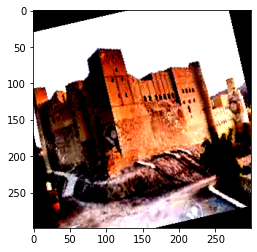

In [ ]:
imgs, lbls = next(iter(train_dl))
img, lbl = imgs[0], lbls[0]
print(lbl)
plt.imshow(img.permute(1,2,0))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, train_dl, test_dl, lr=0.0001, epochs=5, wd=1e-5, per_ep=1,
               amsgrad=False, early_stopping=False, n_epochs_stop=5, criterion=nn.CrossEntropyLoss(),
                save_loc='model'):
    # Using GPU
    model = model.to(device)
    
    # Init params
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, amsgrad=amsgrad)
    min_test_loss = float('inf')
    epoch_no_improve = 0
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
    min_val_loss = float('inf')

    # Training
    for epoch in range(1, epochs+1):
        running_loss = 0.0
        valid_loss = 0.0
        for i, (xb, yb) in enumerate(train_dl):
            model.train()
            imgs, labels = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if (i+1)%len(train_dl)==0 and epoch%per_ep==0:
                model.eval()
                with torch.no_grad():
                    # Get epoch info
                    # train_acc = get_accuracy(model, train_dl)
                    valid_acc = get_accuracy(model, test_dl)
                    train_loss = running_loss / len(train_dl)
                    valid_loss = get_loss(model, test_dl)
                    # print(f'Epoch: {epoch}    Train Loss: {round(train_loss, 6)}    Valid Loss: {round(test_loss, 6)}    Train Accuracy: {round(train_acc, 6)}    valid Accuracy: {round(valid_acc, 6)}')
                    print(f'Epoch: {epoch}    Train Loss: {round(train_loss, 6)}    valid Loss: {round(valid_loss, 6)}    valid Accuracy: {round(valid_acc, 6)}')

                    # #Early Stopping
                    # if epoch_no_improve == n_epochs_stop:
                    #     return
                    # if test_loss > min_test_loss:
                    #     epoch_no_improve += 1
                    # else:
                    #     epoch_no_improve = 0

                    # Reset running loss
                    running_loss = 0.0
        if valid_loss < min_val_loss:
            torch.save(model, save_loc)
        scheduler.step(valid_loss)
    return torch.load(save_loc)

def get_accuracy(model, dataloader):
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        for i, (xb, yb) in enumerate(dataloader):
            imgs, labels = xb.to(device), yb.to(device)
            out = model(imgs)
            _, predicted = torch.max(out, 1)
            correct += (predicted == labels).sum()
            total += len(yb)
    return (correct / total).item()

def get_loss(model, dataloader, criterion=nn.CrossEntropyLoss()):
    model.eval()
    running_loss = 0
    with torch.no_grad():
        for xb, yb in test_dl:
            imgs, labels = xb.to(device), yb.to(device)
            out = model(imgs)
            running_loss += criterion(out, labels)
    return (running_loss / len(test_dl)).item()

# Models

In [ ]:
class ResNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=2, dropout=0.1):
        super(ResNet, self).__init__()
        
        self.conv1 = self.conv_block(in_channels, 32, pool=2, stride=2, dropout=dropout)
        self.resn1 = self.conv_block(32, 32, times=1, dropout=dropout)            # 32 x 64 x 64

        self.conv2 = self.conv_block(32, 64, pool=2, stride=2, dropout=dropout)         
        self.resn2 = self.conv_block(64, 64, times=1, dropout=dropout)            # 64 x 16 x 16

        self.conv3 = self.conv_block(64, 128, pool=2, stride=2, dropout=dropout)        
        self.resn3 = self.conv_block(128, 128, times=1, dropout=dropout)           # 128 x 4 x 4

        self.conv4 = self.conv_block(128, 256, pool=2, stride=1, dropout=dropout)   
        self.resn4 = self.conv_block(256, 256, times=1, dropout=dropout)           # 256 x 2 x 2

        self.fcnl1 = nn.Sequential(nn.AdaptiveMaxPool2d(1), nn.Flatten(), nn.Linear(256, num_classes))
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.resn1(out) + out
        out = self.conv2(out)
        out = self.resn2(out) + out
        out = self.conv3(out)
        out = self.resn3(out) + out
        out = self.conv4(out)
        out = self.resn4(out) + out
        out = self.fcnl1(out)
        return out
    
    def conv_block(self, in_channels, out_channels, pool=1, times=1, stride=1, dropout=0):
        layers = []
        for _ in range(times):
            layers += [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)]            
            layers += [nn.ReLU(inplace=True)]
            layers += [nn.MaxPool2d(pool)] if pool else []
            layers += [nn.Dropout2d(dropout)]
            layers += [nn.BatchNorm2d(out_channels)]
        return nn.Sequential(*layers)

In [ ]:
# %%time
res_model = ResNet(num_classes=n_classes, dropout=0.1)
train_model(res_model, train_dl, valid_dl, lr=0.001, epochs=20, wd=0.1, amsgrad=True, per_ep=1)

Epoch: 1    Train Loss: 3.22897    valid Loss: 2.700659    valid Accuracy: 0.231579
Epoch: 2    Train Loss: 2.723741    valid Loss: 2.470518    valid Accuracy: 0.268421
Epoch: 3    Train Loss: 2.504413    valid Loss: 2.403666    valid Accuracy: 0.331579
Epoch: 4    Train Loss: 2.365512    valid Loss: 2.211895    valid Accuracy: 0.289474
Epoch: 5    Train Loss: 2.208166    valid Loss: 2.088708    valid Accuracy: 0.373684
Epoch: 6    Train Loss: 2.076633    valid Loss: 2.070534    valid Accuracy: 0.373684
Epoch: 7    Train Loss: 1.976399    valid Loss: 2.099473    valid Accuracy: 0.363158
Epoch: 8    Train Loss: 1.910461    valid Loss: 2.008297    valid Accuracy: 0.4
Epoch: 9    Train Loss: 1.795375    valid Loss: 1.927837    valid Accuracy: 0.394737
Epoch: 10    Train Loss: 1.75233    valid Loss: 1.894325    valid Accuracy: 0.431579
Epoch: 11    Train Loss: 1.630569    valid Loss: 2.010959    valid Accuracy: 0.405263
Epoch: 12    Train Loss: 1.611501    valid Loss: 1.95154    valid Accu

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (resn1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [ ]:
class ResNet_32x32(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super(ResNet_32x32, self).__init__()
        
        self.conv1 = self.conv_block(in_channels, 32, pool=2)
        self.resn1 = self.conv_block(32, 32, times=1)            # 32 x 16 x 16

        self.conv2 = self.conv_block(32, 64, pool=2)         
        self.resn2 = self.conv_block(64, 64, times=1)            # 64 x 8 x 8

        self.conv3 = self.conv_block(64, 128, pool=2)        
        self.resn3 = self.conv_block(128, 128, times=1)           # 128 x 4 x 4

        self.conv4 = self.conv_block(128, 256, pool=2)   
        self.resn4 = self.conv_block(256, 256, times=1)           # 256 x 2 x 2

        self.fcnl1 = nn.Sequential(nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(256, num_classes))
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.resn1(out) + out
        out = self.conv2(out)
        out = self.resn2(out) + out
        out = self.conv3(out)
        out = self.resn3(out) + out
        out = self.conv4(out)
        out = self.resn4(out) + out
        out = self.fcnl1(out)
        return out
    
    def conv_block(self, in_channels, out_channels, pool=1, times=1, stride=1):
        layers = []
        for _ in range(times):
            layers += [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1), 
                       nn.ReLU(inplace=True),
                       nn.BatchNorm2d(out_channels)]
            if pool:
                layers += [nn.MaxPool2d(pool)]
        return nn.Sequential(*layers)

In [ ]:
# %%time
res_model = ResNet_32x32(num_classes=n_classes)
train_model(res_model, train_dl, valid_dl, lr=0.0001, epochs=10, wd=0, amsgrad=True, per_ep=1)

Epoch: 1    Train Loss: 3.265235    Train Accuracy: 0.12738    valid Accuracy: 0.082353
Epoch: 2    Train Loss: 2.973092    Train Accuracy: 0.173999    valid Accuracy: 0.052941


KeyboardInterrupt: ignored

# Transfer Learning

In [ ]:
import joblib
from PIL import Image
from torchvision.models import resnet18, resnet50, resnet152, inception_v3

In [ ]:
model = resnet50(pretrained=True)

# Freeze model weights
ct = 0
for child in model.children():
    ct += 1
    if ct <= 7:
        for param in child.parameters():
            param.requires_grad = False

# Add on classifier
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, n_classes),
)

train_model(model, train_dl, valid_dl, lr=0.0001, epochs=20, wd=0.1, per_ep=1, amsgrad=True)

Epoch: 1    Train Loss: 2.752468    valid Loss: 2.272213    valid Accuracy: 0.352632


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f88e89cf680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f88e89cf680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 2    Train Loss: 1.895255    valid Loss: 1.662465    valid Accuracy: 0.584211
Epoch: 3    Train Loss: 1.264715    valid Loss: 1.18335    valid Accuracy: 0.731579
Epoch: 4    Train Loss: 0.856519    valid Loss: 1.015849    valid Accuracy: 0.742105


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f88e89cf680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f88e89cf680>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f88e89cf680>

Epoch: 5    Train Loss: 0.623871    valid Loss: 0.935635    valid Accuracy: 0.778947
Epoch: 6    Train Loss: 0.445141    valid Loss: 0.927308    valid Accuracy: 0.763158
Epoch: 7    Train Loss: 0.311548    valid Loss: 0.927857    valid Accuracy: 0.726316
Epoch: 8    Train Loss: 0.238881    valid Loss: 0.910158    valid Accuracy: 0.721053
Epoch: 9    Train Loss: 0.192605    valid Loss: 0.979999    valid Accuracy: 0.721053
Epoch: 10    Train Loss: 0.138076    valid Loss: 1.003296    valid Accuracy: 0.736842
Epoch: 11    Train Loss: 0.109722    valid Loss: 1.03095    valid Accuracy: 0.784211
Epoch: 12    Train Loss: 0.084689    valid Loss: 0.838972    valid Accuracy: 0.763158
Epoch: 13    Train Loss: 0.072105    valid Loss: 1.019912    valid Accuracy: 0.768421
Epoch: 14    Train Loss: 0.067835    valid Loss: 1.025713    valid Accuracy: 0.757895
Epoch: 15    Train Loss: 0.075778    valid Loss: 1.009659    valid Accuracy: 0.763158
Epoch: 16    Train Loss: 0.053545    valid Loss: 1.006976   

In [ ]:
sum(1 for child in model.children())

10

In [ ]:
torch.save(model, 'resnet.model')

In [ ]:
model = inception_v3(pretrained=True)

# Freeze model weights
ct = 0
for child in model.children():
    ct += 1
    if ct <= 8:
        for param in child.parameters():
            param.requires_grad = False

# Add on classifier
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 256),
    nn.ReLU(inplace=True),
    nn.Linear(256, n_classes),
)
model.aux_logits = False

# model
model = train_model(model, train_dl, valid_dl, lr=0.0001, epochs=20, wd=0.1, per_ep=1, amsgrad=True, save_loc='inception.model')

Epoch: 1    Train Loss: 2.908843    valid Loss: 2.631812    valid Accuracy: 0.236842
Epoch: 2    Train Loss: 2.32756    valid Loss: 1.935455    valid Accuracy: 0.457895
Epoch: 3    Train Loss: 1.607804    valid Loss: 1.344579    valid Accuracy: 0.605263
Epoch: 4    Train Loss: 1.027777    valid Loss: 0.996942    valid Accuracy: 0.710526
Epoch: 5    Train Loss: 0.659325    valid Loss: 0.95721    valid Accuracy: 0.768421
Epoch: 6    Train Loss: 0.477533    valid Loss: 0.932275    valid Accuracy: 0.757895
Epoch: 7    Train Loss: 0.330576    valid Loss: 0.910395    valid Accuracy: 0.763158
Epoch: 8    Train Loss: 0.240074    valid Loss: 0.959491    valid Accuracy: 0.710526
Epoch: 9    Train Loss: 0.197411    valid Loss: 0.957964    valid Accuracy: 0.757895
Epoch: 10    Train Loss: 0.136901    valid Loss: 0.928583    valid Accuracy: 0.752632
Epoch: 11    Train Loss: 0.094429    valid Loss: 0.921868    valid Accuracy: 0.773684
Epoch: 12    Train Loss: 0.087916    valid Loss: 1.02427    valid

KeyboardInterrupt: ignored

In [ ]:
torch.save(model.cpu(), 'inception.model')

# Save for Deployment

In [ ]:
models_loc = '/content/drive/MyDrive/Cicerone/models/'

In [ ]:
class Cicerone_Inception():
    def __init__(self):
        self.model = torch.load('inception.model').cpu()
        self.classes = ['Al Alam Palace',
                        'Al Sawadi Beach',
                        'Arabian Oryx Sanctuary',
                        'Ayn Athum, Salalah',
                        'Bahla Fort',
                        'Bait Al Baranda Museum',
                        'Bait Al Zubair Museum',
                        'Bandar Al Khairan Viewpoint',
                        'Hawana Aqua Park',
                        'Jebel Shams',
                        'Jibreen Castle',
                        'Khuriya Muriya Islands',
                        'Musandam Oman',
                        'Musandam Peninsula',
                        'Mutrah Fort',
                        'Nakhal Fort, Oman',
                        'Nizwa Fort',
                        'Royal Opera House Muscat',
                        'Snake Gorge Canyon',
                        'Sultan Qaboos Grand Mosque',
                        'Telegraph Island',
                        'The Museum of the Frankincense Land',
                        'Wadi Ash Shab',
                        'Wadi Darbat',
                        'Wadi Dayqah Dam']

    def predict_image_path(self, image_path):
        from torchvision import transforms
        from PIL import Image
        import torch
        image_size=(299,299)
        tm = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        image = Image.open(image_path)

        image = tm(image)
        image = image.unsqueeze(0) 

        with torch.no_grad():
            out = self.model(image.cpu())
            index = out.numpy().argmax()
        return self.classes[index]

In [ ]:
cc_model = Cicerone_Inception()
joblib.dump(cc_model, models_loc+'cicerone_inception.model')

['/content/drive/MyDrive/Cicerone/models/cicerone_inception.model']

In [ ]:
loaded_model = joblib.load(models_loc+'cicerone_inception.model')
loaded_model.predict_image_path('/content/image.jpeg')

'Sultan Qaboos Grand Mosque'

In [ ]:
class Cicerone_Resnet():
    def __init__(self):
        self.model = torch.load('resnet.model').cpu()
        self.classes = ['Al Alam Palace',
                        'Al Sawadi Beach',
                        'Arabian Oryx Sanctuary',
                        'Ayn Athum, Salalah',
                        'Bahla Fort',
                        'Bait Al Baranda Museum',
                        'Bait Al Zubair Museum',
                        'Bandar Al Khairan Viewpoint',
                        'Hawana Aqua Park',
                        'Jebel Shams',
                        'Jibreen Castle',
                        'Khuriya Muriya Islands',
                        'Musandam Oman',
                        'Musandam Peninsula',
                        'Mutrah Fort',
                        'Nakhal Fort, Oman',
                        'Nizwa Fort',
                        'Royal Opera House Muscat',
                        'Snake Gorge Canyon',
                        'Sultan Qaboos Grand Mosque',
                        'Telegraph Island',
                        'The Museum of the Frankincense Land',
                        'Wadi Ash Shab',
                        'Wadi Darbat',
                        'Wadi Dayqah Dam']

    def predict_image_path(self, image_path):
        from torchvision import transforms
        from PIL import Image
        import torch
        image_size=(256,256)
        tm = transforms.Compose([
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        image = Image.open(image_path)

        image = tm(image)
        image = image.unsqueeze(0) 

        with torch.no_grad():
            out = self.model(image.cpu())
            index = out.numpy().argmax()
        return self.classes[index]

In [ ]:
cc_model = Cicerone_Resnet()
joblib.dump(cc_model, models_loc+'cicerone_resnet.model')

NameError: ignored

In [ ]:
loaded_model = joblib.load(models_loc+'cicerone_resnet.model')
loaded_model.predict_image_path('/content/image.jpeg')